<a href="https://colab.research.google.com/github/curiotiks/webspace/blob/main/self-efficacy/se_ecd_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext rpy2.ipython 

In [ ]:
%%capture
%%R
install.packages("BayesFM")
install.packages("reshape")

In [ ]:
%%capture
%%R
library(tidyverse)
library(reshape)
library(BayesFM)
path <- "/content/drive/MyDrive/(ECD) Self-efficacy Measurement/se_ecd"

In [ ]:
%%R
twine <-
    read.csv(paste0(path,"/twine_data.csv")) %>%
    mutate(across(.cols = choice_1:choice_9, ~factor(.x, levels = c("Low", "Medium", "High"))))

table(twine$choice_1:twine$choice_9)


      Low:Low    Low:Medium      Low:High    Medium:Low Medium:Medium 
            0             0             0             1             0 
  Medium:High      High:Low   High:Medium     High:High 
            1             0             5             2 


From the table, it looks like most ranked themselves pretty high. I would expect something similar from the Qualtrics as well. I can make comparisons between individual columns. But I was to run an EFA model first.

In [ ]:
%%R
num_twine <-
    twine %>%
    mutate(across(.cols = choice_1:choice_9, ~as.numeric(.x))) %>%
    select(choice_1:choice_9)
num_twine

  choice_1 choice_2 choice_3 choice_4 choice_5 choice_6 choice_7 choice_8
1        2        3        2        3        2        3        3        2
2        3        3        2        3        3        3        3        3
3        3        1        1        2        3        3        3        3
4        2        2        2        2        2        3        3        2
5        3        3        2        3        2        3        3        3
6        3        3        1        3        3        3        2        3
7        3        1        2        2        3        3        3        2
8        3        2        2        1        3        3        3        3
9        3        2        1        3        3        3        2        3
  choice_9
1        1
2        3
3        2
4        3
5        2
6        2
7        2
8        2
9        3


# Correlation
* I've dropped `choice_6` because everyone answered "high", so it's returning NA when I try to do anything with it
* Recoding the "high", "medium", and "low" factors to 3, 2, and 1 respectively. 

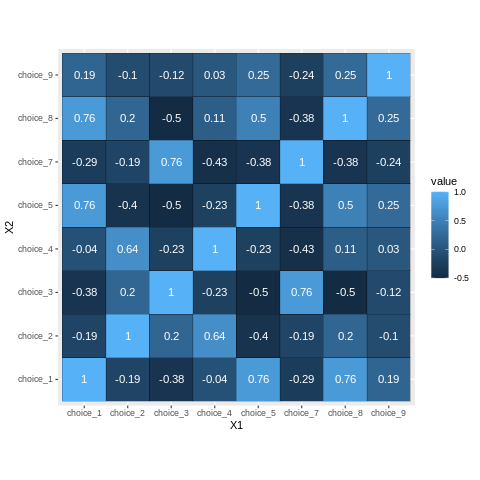

In [ ]:
%%R
cor <- cor(num_twine[-6]) %>% round(., 2)
cor <- reshape::melt(cor) %>% arrange(value)

ggplot2::ggplot(data = cor,
                aes(x = X1,
                    y = X2, 
                    fill = value)) +
                geom_tile(color = "black") +
                geom_text(aes(label = value), color = "white", size = 4) +
                coord_fixed()

* I already decided `choice_6` was no good. Everyone answers high.
* `Choice_7` seems to be poorly correlated with most of the other questions. 
* `Choice_3` is another that doesn't seem to fit well with many others. 
* But `Choice_3` and `choice_7` seemed to be related (*r* = .76)

The issue with `choice_6` may have been that it was too procedural. The question was asking about calculating points needed to pass a test. This may have been too basic of a skill that most participants would feel comfortable completing the procedure.

> C6: Five grammar tests are to be given to your English class. Each test has a value of 30 points. You have to have an average of higher than 80% on all the tests to pass this course. 

For `choice_3` and `choice_7`:

> C3: Course enrollment for the next semester has opened and you are enrolling. Earlier in the afternoon another student told you that the three available courses are quite different. The course taught by Dr. Sim’s course is easy to pass with little effort. Dr. Rogers requires decent work, but is manageable. Dr. Torrin’s class, however, requires a lot of work and her tests are hard but you will learn. 

> C7: You just graduated and are looking for a job. Finally, an offer comes, but it’s a job you didn’t think you could get. The job pays well, but requires working with more technical details than you anticipated. You’ll be working with quite a few mathematical processes you’re not sure you remember. 

`choice_7` is mostly "high", but this could be related to the incentive of financial gain, as we suspected. I'm also not surprised by `choice_3`. I would expect only those with the highest efficacy would choose the harder class. But nearly everyone selected "medium". Again, this may be more related to the burden of taking classes rather than personal challenge. If we surveyed STEM majors, the responses may be different.


# Factor Analysis

In [ ]:
%%R
model <- befa(num_twine,
              burnin = 10000,
              iter = 1000000)
post_model <- post.column.switch(model)
post_model <- post.sign.switch(post_model)
summary(post_model)

starting MCMC sampling...
done with burn-in period
    5%
   10%
   15%
   20%
   25%
   30%
   35%
   40%
   45%
   50%
   55%
   60%
   65%
   70%
   75%
   80%
   85%
   90%
   95%
  100%
done with sampling!
BEFA - Bayesian Exploratory Factor Analysis
Summary of posterior results

Maximum number of factors (Kmax) = 3 
Identification restriction (Nid) = 3 

MCMC iterations = 1e+06 
burn-in period  = 10000 

Metropolis-Hastings acceptance rate = 0.95

Posterior frequency of number of latent factors:
  K =  1     98.51%

-----------------------------------------------------------------
Model parameters

Factor loadings:

                 dedic    prob    mean      sd   [ 95%   hpd ]
alpha:choice_1       1   1.000   2.979   0.802   1.681   4.577
alpha:choice_2       1   0.990   2.387   0.693   1.235   3.768
alpha:choice_3       1   0.991   1.773   0.518   0.915   2.815
alpha:choice_4       1   0.991   2.619   0.737   1.422   4.107
alpha:choice_5       1   0.995   2.857   0.777   1.607  

# Relation with objective measure (i.e., Qualtrics)


In [ ]:
%%R
q_levels <- c("Not at all confident", "Slightly confident", "Moderately confident", "Very confident", "Completely confident")
edu_levels <- c("Less than high school degree", "High school graduate (high school diploma or equivalent including GED)", 
                "Some college but no degree", "Associate degree in college (2-year)", "Bachelor's degree in college (4-year)", 
                "Master's degree", "Doctoral degree", "Professional degree (JD, MD)")
qu <- 
    read.csv(paste0(path, "/qualtrics.csv")) %>%
    select(uid:major) %>%
    mutate(
        across(.cols = Q1:Q16, ~as.numeric(factor(.x, levels = q_levels))),
        education = factor(education, levels = edu_levels),
        race = factor(race, levels = c("Asian", "White")),
        gender = factor(gender, levels = c("Male", "Female")),
        income = factor(income), 
        stem_major = ifelse(stem_major == "Yes", TRUE, FALSE)
        )

In [139]:
%%R

df <-
    twine %>%
    select(-c(Timestamp)) %>%
    mutate(across(.cols = choice_1:choice_9, ~as.numeric(.x))) %>%
    left_join(qu, ., by = "uid") %>%
    rowwise() %>%
    mutate(sb_comp = sum(choice_1:choice_9),
           obj_comp = sum(Q1:Q16, na.rm = TRUE)
           )

df$sb_comp_z <- round(scale(df$sb_comp)[,1],3)
df$obj_comp_z <- round(scale(df$obj_comp)[,1],3)

cor(df$sb_comp, df$obj_comp, use = "complete.obs", method = "spearman")

[1] 0.1710798


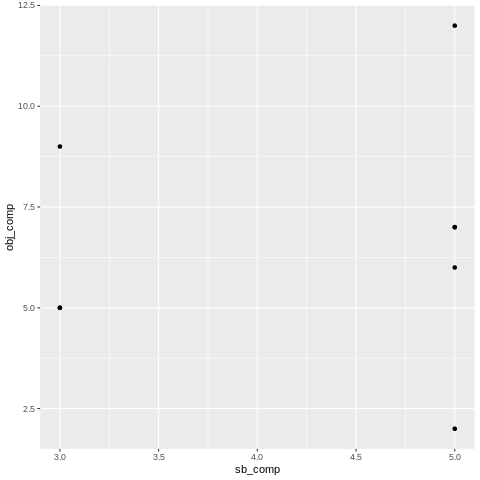

In [142]:
%%R
df %>%
ggplot(aes(x = sb_comp, y = obj_comp)) +
geom_point()

So, not great. Could be an issue with sample size. Obviously we don't have enough various to say anything definitive. But what is here is not great. 

In [144]:
%%R
df_factors <- df %>% select(choice_1:choice_9, Q1:Q16)
model <- befa(df_factors,
              burnin = 10000,
              iter = 1000000)
post_model <- post.column.switch(model)
post_model <- post.sign.switch(post_model)
summary(post_model) 

starting MCMC sampling...
done with burn-in period
    5%
   10%
   15%
   20%
   25%
   30%
   35%
   40%
   45%
   50%
   55%
   60%
   65%
   70%
   75%
   80%
   85%
   90%
   95%
  100%
done with sampling!
BEFA - Bayesian Exploratory Factor Analysis
Summary of posterior results

Maximum number of factors (Kmax) = 8 
Identification restriction (Nid) = 3 

MCMC iterations = 1e+06 
burn-in period  = 10000 

Metropolis-Hastings acceptance rate = 0.759

Posterior frequency of number of latent factors:
  K =  1     49.90%
  K =  2     31.18%
  K =  3     15.78%

-----------------------------------------------------------------
Model parameters

Factor loadings:

                 dedic    prob    mean      sd   [ 95%   hpd ]
alpha:choice_1       1   1.000   2.764   0.793   1.479   4.335
alpha:choice_2       1   0.746   2.205   0.685   1.078   3.576
alpha:choice_3       1   0.801   1.696   0.515   0.853   2.723
alpha:choice_4       1   0.832   2.448   0.729   1.265   3.904
alpha:choice_5 